- start with standard brain atlas like Desikan-Killany, N=84
- consider each region as a "multihead block" (MH)
- subdivide each region in H heads, resulting in NxH nodes, e.g. H=8, ~700 total heads
- each head has a matrix-valued state S
	- `q_t, v_t, k_t = Wqkv @ x_t` for afferent input `x_t`
	- `S_{t+1} = decay*S_t + v_t @ k_t`
	- output `o_t = S_t @ q_t` 
	- tho I would still like to do DeltaNet to have a prediction error based update
- output of MH is sum over heads within block, generating a vector-valued output
- structural connectivity  (NxN) applied the transmission of vector valued "token" (coupling variables for tvb)

In [1]:
%pylab inline
import numpy as np

# dimensions
N = 84  # number of brain regions
H = 8   # number of heads per region
D = 16  # dimension of each head's state
decay = 0.9  # decay factor for state update

# parameters
C = np.random.randn(N, N)  # connectivity matrix between regions
Wqkv = np.random.randn(3, N, H, D, D)  # weights for Q, K, V
Wout = np.random.randn(N, H, D, D)    # output weights

# states
S = np.random.randn(N, H, D, D)  # state matrix for each head
x = np.random.randn(N, D)  # input vector for each region

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# now we can loop this for multiple time steps
T = 16
xs = []
for t in range(T):
    # q, k, v = Wqkv @ x
    q, k, v = np.einsum('nd,TnhdD->TnhD', x, Wqkv)
    # S_{t+1} = decay*S_t + v_t @ k_t
    S = decay*S + np.einsum('nhi,nhj->nhij', v, k)
    # o_t = S_t @ q_t
    o = np.einsum('nhij,nhj->nhi', S, q)
    # o_t = o_t @ Wout
    o = np.einsum('nhij,nhj->ni', Wout, o)
    # apply connectivity
    x = np.einsum('ij,jd->id', C, o)
    xs.append(x.copy())
xs = np.array(xs)  # shape (T, N, D)

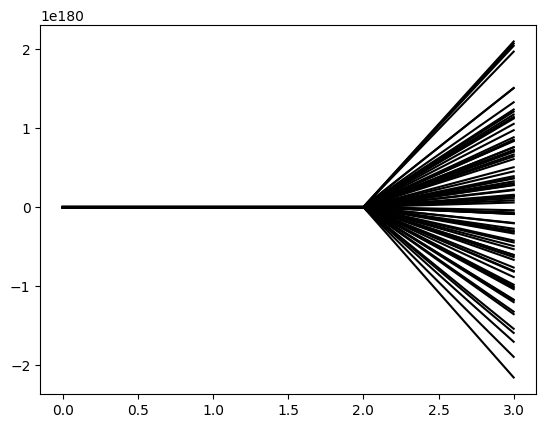

In [3]:
plot(xs[:, :, 0], 'k');  # plot first dimension of each region over time

So it's not stable for now, w/o any training.